# A. Importing standard libraries and user-defined libraries

In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Multiple_Max_Ent_evs as HBProjEv

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

# B. Defining the system

## 1. Ferromagnetic XX-model's Hamiltonian

We start by considering a ferromagnetic XX-Heisenberg-like six-site lattice, with closed boundary conditions, acting on the system's Hilbert space,  $\bigotimes_{i=1}^{N=6}{\bf C}^2$.

In order to do that, we invoke *b_spin_representations'* s module "one_body_spin_ops" which constructs the appropiate local one-body Pauli operators acting on the full Hilbert's space, i.e.

$$
    {\bf S}_{{x,y,z}}^{j} = \textrm{id}_2 \otimes \cdots \otimes {\bf S}_{{x,y,z}}^{j} \otimes \cdots \otimes \textrm{id}_2
$$

where a total of $j-1$ identity operators act on the left, while a total of $N-j$ identity operators act on the right. 


In [2]:
k_B = 1; temp = 1e+1; temp_ref = 1e+1 ### natural units scale and temperatures

N=6; chain_type = "XX"
spin_ops_list = su2.one_body_spin_ops(size = N) ### One body local spin operators
identity_op = spin_ops_list[0][0]

Hamiltonian_paras = [-1e-1, -2.5e-1, 0., .5e-1]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False) ### Heisenberg Hamiltonian

## 2. Defining the set of classical operators

We define the set of classical operators, by invoking *{b_spin_representations}'* s module "classical_ops". A test is implemented to check that these are, in fact, physical observables, i.e. Hermitian operators.

In [3]:
### Some observables of interest

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

cl_ops["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; label_ops.append("n_oc_op_sq")

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True]


## 3. Observables of interest

A subset of physical observables, whose time evolution of its expectation value is of interest, is defined

In [4]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")

# 4. Referential state

In the restricted Max-Ent evolution algorithm, the system's initial state is recursively defined in terms of a referential state $\sigma_{\textrm{ref}}$ and an orthogonalization procedure, which will be treated later on. 
This referential state can be obtained as a Max-Ent state with respect to a known basis of operators ${\cal B} = \{{\cal O}_{\alpha}\}^{\alpha}$, with some real-valued weights $(\lambda_{\alpha})^{\alpha} \in {\bf R}$.
Then, the referential state reads 

$$
    \sigma_{\textrm{ref}} \propto \exp \bigg( 
                                              - \beta_{\textrm{ref}} \sum_{\alpha} \lambda_{\alpha} {\cal O}_{\alpha}
                                                \bigg)
$$

s.t. $\sigma_{\textrm{ref}}$ has unitary trace. It is clear, from such construction, that $\sigma_{\textrm{ref}}$ is a well-defined density operator, lying on the system's phase space. 

In particular, we are interested in the following state,

$$
    \sigma_{\textrm{ref}} \propto e^{-  \beta_{\textrm{ref}} {\bf K}_{\textrm{ref}}}, 
    \textrm{ s.t. } {\bf K}_{\textrm{ref}} = c_1 {\bf H} + c_2 (\hat{{\bf n}} - \zeta)^2 + c_3 \hat{{\bf x}}
$$

with $c_1, c_2, c_3, \zeta$ chosen s.t. $\langle \hat{\bf n} \rangle_{\sigma_{\textrm{ref}}} \approx 1$. The previous state's logarithm, i.e. its ${{\bf K}_{\textrm{ref}}}$ operator, may be expanded in terms of the following ${\cal B}$-basis 

$$
    {\cal B} = \{\textrm{id}, {\bf H}, \hat{{\bf n}}, \hat{{\bf n}}^2, \hat{{\bf x}}\}
$$


In [5]:
beta_ref = (1/temp_ref); c1 = 30; c2 = 5; c3 = 30; zeta = .5
calB_basis_0 = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"]]
coeff_basis_t0 = [beta_ref * zeta**2,
                  beta_ref * c3,
                  (-2) * beta_ref * zeta * c1, 
                  beta_ref * c1, 
                  beta_ref * c2]
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))

For numerical stability, it is convenient to substract ${{\bf K}_{\textrm{ref}}}$'s maximum eigenvalue, i.e. 

$$
    {{\bf K}_{\textrm{ref}}} \mapsto {{\bf K}_{\textrm{ref}}} - \lambda_{\max}({{\bf K}_{\textrm{ref}}}),
$$

s.t. the modified ${{\bf K}_{\textrm{ref}}}$ operator has only negative eigenvalues. Should this step be omitted, matrix exponentiation could be very error-prone. After these calculations, a test is imposed to check whether or not $\sigma_{\textrm{ref}}$ is a density matrix. 

In [6]:
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = (K_ref_A - max(K_ref_A.eigenenergies()) * identity_op).expm()
coeff_basis_t0[0] = np.log(rho_ref.tr())
K_ref_A = -sum(coeff_basis_t0[a] * calB_basis_0[a] for a in range(len(calB_basis_0)))
rho_ref = (rho_ref)/rho_ref.tr()
assert mat_ansys.is_density_op(rho_ref), "Reference state not a density operator"
fixed_op_list = calB_basis_0.pop()

In [7]:
print('<n>=', qutip.expect(rho_ref, cl_ops["n_oc_op"]))

<n>= 0.9706016272445455


## 5. Setting up the restricted Max-Ent evolutions  

An important parameter of a restricted Max-Ent evolution is the dimension of its associated Hierarchical Basis.
A Hierarchical Basis is defined as follows,

$$
    \cal{B}^{\ell} = \cal{B}^{0} + \cal{B}^{1}, 
$$

where $\cal{B}^{0}=\{\textrm{id}, {\bf H}, \hat{{\bf n}}, \hat{{\bf n}}^2, \hat{{\bf x}}\} $ and where $\cal{B}^{1}$ includes a total of $\ell$ iterated commutators, with respect to a fixed, known, and physically relevant, seed operator, ${\bf A}$, i.e.

$$
    \cal{B}^{1} = \{\textrm{[}{\bf H}, {\bf A}\textrm{]}, \textrm{[}{\bf H},\textrm{[}{\bf H},{\bf A}\textrm{]}\textrm{]} \cdots\}
$$

The complete set $\cal{B}^{\ell}$ is then a $(\ell + 4)$-dimensional basis on a subspace $\bar{\cal B}^{\ell}$ of Hermitian operators ${\bf K}$. Exponentiation of these ${\bf K}$ operators gives rise to a subspace of density matrices, ${\cal V}^{\ell}$, i.e. 

$$
    {\cal V}^{\ell} = \{ \sigma : \sigma \propto e^{-{\bf K}} \textrm{ with } {\bf K} = \sum_{\alpha} \lambda_{\alpha} \bar{\bf O}_{\alpha}  \}
$$

The main advantage of this construction is that the evolution is closed on each ${\cal V}^{\ell}$ subspace. 
Here, we specify how many commutators are to be included in each restricted Max-Ent evolution.

In [11]:
range_derived_series_orders = depth_parameters = [1, 3, 6]
all_coeff_list = [coeff_basis_t0 + list(np.zeros(a)) for a in depth_parameters]

In particular, we have chosen to compute three, separate, restricted evolutions for three different Hierarchical bases, with one, three and six iterated commutators, respectively. 
Moreover, we also specify the initial configuration of numbers $\{\lambda_{\alpha}(0)\}^\alpha$, characterizing the initial state's expansion in terms of the basis $\cal{B}^{\ell}$

In [12]:
all_coeff_list

[[0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0],
 [0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0, 0.0, 0.0],
 [0.740788476379098, 3.0, -3.0, 3.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

# C. Exact and restricted Max-Ent evolutions for the XX chain

Here, we carry out the exact and the three restricted Max-Ent evolutions. 

## 1. Time grid
We start by specifying the desired times, for which observables and states for each evolution is desired.

In [13]:
ts = np.linspace(1e-1, 4., 500)

## 2. Computing the evolutions
Next, we invoke *e_Multiple_Max_Ent_evs*'s module, "multiple_MaxEnt_evs", to perform and compute several quantities of interest, e.g. 

* the exact and approximate expected values of the observables chosen in B.3, 
* the exact density states, $\rho$, and the restricted Max-Ent states, $\sigma$, for each chosen approximate evolution. 

If a referential state, $\sigma_{\textrm{ref}}$, and the dimension of the basis, $\ell$, is known, how does the restricted Max-Ent evolution algorithm work?

1. First, the ${\cal B}^{\ell}$ is constructed, by calculated a total of $\ell$ iterated commutators, using the $\hat{\bf x}$ operator as a seed operator. Each operator is constructed s.t. it has zero expected value with respect to the referential state  

2.

In [15]:
resultados = HBProjEv.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0,
                                                    rho_ref = rho_ref, 
                                                    range_HierarchBases_dims = depth_parameters, 
                                                     temp_ref = temp_ref, temp_rho = temp,
                                                     generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

Processing step:  1  and hierarchical basis of ℓ=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the

Next, these results are plotted using *c_evs_visualization_tools*'s module, "plot_exact_v_proj_ev_avgs_multiple", which allows for easy comparison of the exact and restricted Max-Ent expected values.

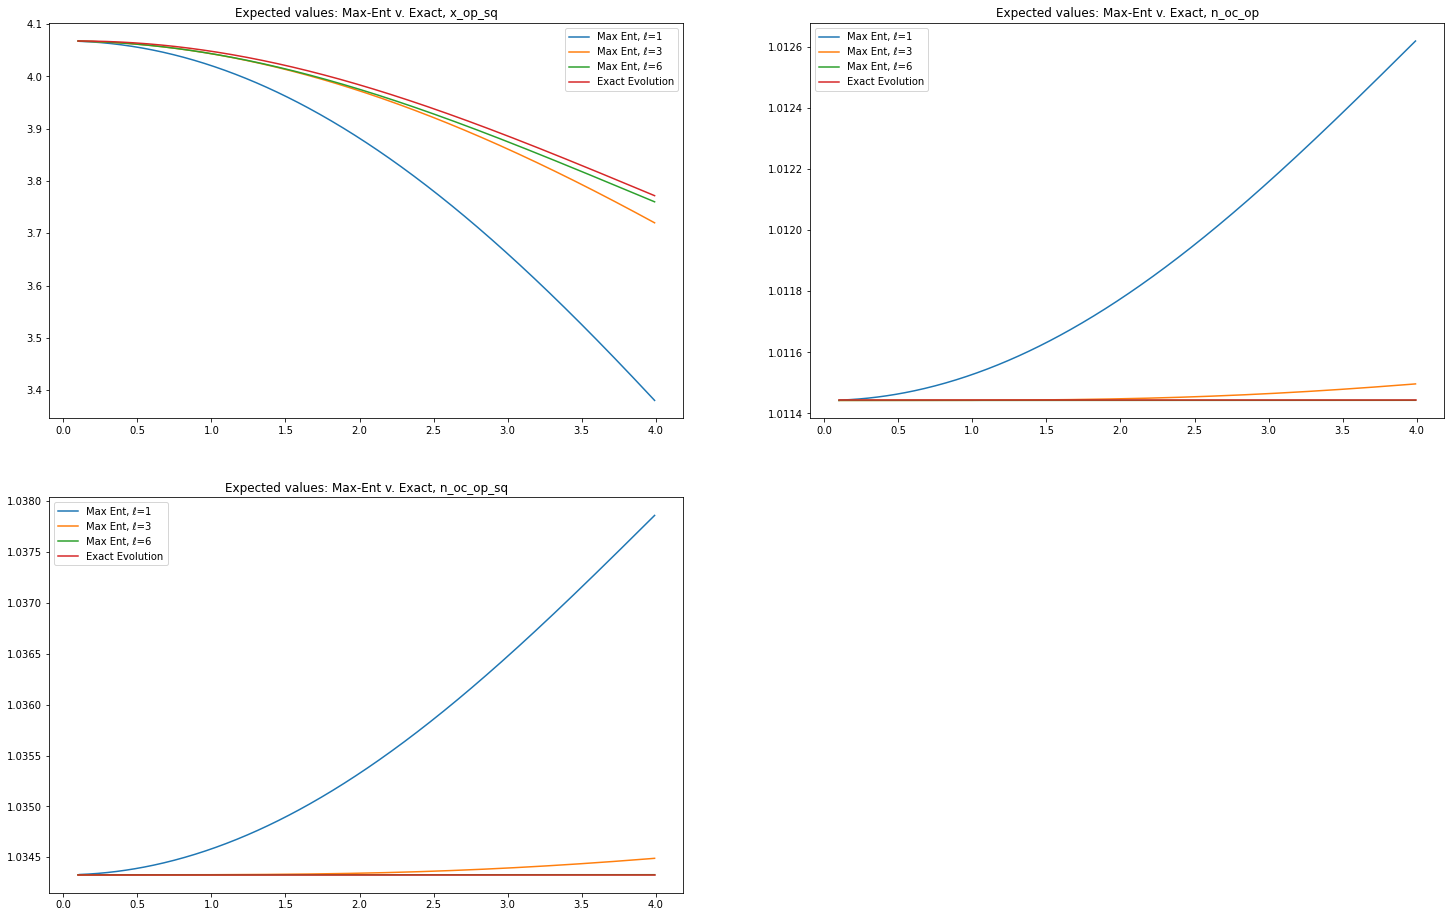

In [16]:
evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                                                 timespan = ts,
                                                 no_cols_desired = 2,
                                                 multiple_evolutions = resultados,
                                                 range_of_temps_or_dims = depth_parameters,
                                                  plot_var_HierarchBases_dim = True)

In [137]:
### Test: 
rho0_HB0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho0"]
rho0_HB1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho0"]
rho0_HB2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho0"]
rho0_exact = resultados["res_exact"]['res_exact_MaxEnt2'].states[0]

print(r'Are all initial states, $\rho_0$, equal for all evolutions?')
rho0_HB0 == rho0_HB1 == rho0_HB2 == rho0_exact

n_oc_op_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][1]
n_oc_op_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][1]
n_oc_op_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][1]
n_oc_op_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[1]
res_n_evs = [n_oc_op_exact[:-1], n_oc_op_HB0, n_oc_op_HB1, n_oc_op_HB2]

n_oc_op_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][2]
n_oc_op_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][2]
n_oc_op_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][2]
n_oc_op_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[2]
res_n_sq_evs = [n_oc_op_sq_exact, n_oc_op_sq_HB0, n_oc_op_sq_HB1, n_oc_op_sq_HB2]

n_oc_std_exact = [(n_oc_op_sq_exact[m] - n_oc_op_exact[m]**2) for m in range(len(n_oc_op_sq_exact))]
n_oc_std_HB0 = [(n_oc_op_sq_HB0[m] - n_oc_op_HB0[m]**2) for m in range(len(n_oc_op_sq_HB0))]
n_oc_std_HB1 = [(n_oc_op_sq_HB1[m] - n_oc_op_HB1[m]**2) for m in range(len(n_oc_op_sq_HB1))]
n_oc_std_HB2 = [(n_oc_op_sq_HB2[m] - n_oc_op_HB2[m]**2) for m in range(len(n_oc_op_sq_HB2))]

n_oc_std_all_evs = [n_oc_std_exact[:-1], n_oc_std_HB0, n_oc_std_HB1, n_oc_std_HB2]
labels = [", Ex", ", ℓ=1", ", ℓ=3", ", ℓ=6"]

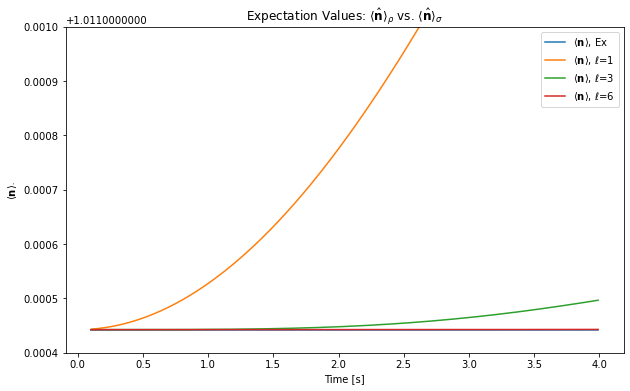

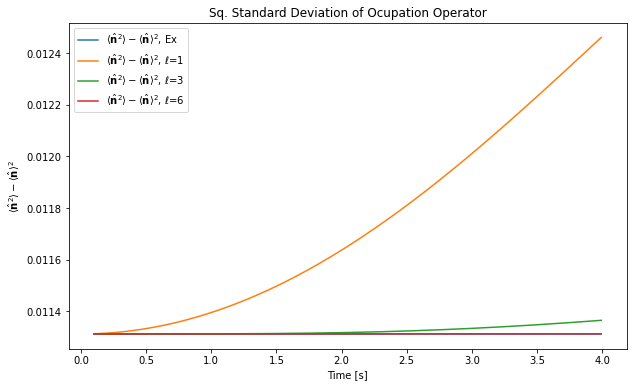

In [144]:
fig0, ax0 = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], res_n_evs[n], label = r'$\langle {\bf n} \rangle$' + labels[n])

plt.ylim(1.0114, 1.012)
ax0.legend(loc=0)
ax0.set_xlabel(r'Time [s]')
ax0.set_ylabel(r'$\langle {\bf n} \rangle_{\cdot}$')
ax0.set_title(r'Expectation Values: $\langle \hat{{\bf n}} \rangle_{\rho} $ vs. $\langle \hat{{\bf n}} \rangle_{\sigma}$');

fig, ax = plt.subplots(figsize=(10,6))

for n in range(len(n_oc_std_all_evs)):
    plt.plot(ts[:-1], n_oc_std_all_evs[n], label = r'${\langle \hat{{\bf n}}^2 \rangle - \langle \hat{{\bf n}}\rangle^2}$' + labels[n])

ax.legend(loc=0)
#plt.ylim(0.0113, 0.00114)
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'${\langle \hat{{\bf n}}^2 \rangle - \langle \hat{{\bf n}}\rangle^2}$')
ax.set_title(r'Sq. Standard Deviation of Ocupation Operator');

Furthermore, we compute some relevant matrix metrics of both mathematical and physical interest, namely the Bures metric and both types of relative entropies. 

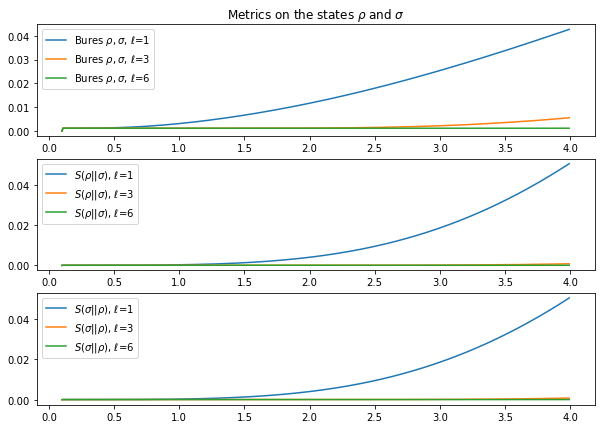

In [17]:
metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = depth_parameters,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = depth_parameters,
                                                     metric_local = metrics, cols = 1,
                                         plot_var_HierarchBases_dim = True)

## 3. Analyzing the validity of the results

Even though the previously-invoked modules continously perform tests on the results, to check their correctness, before printing them out, it is convenient to analyze some interesing quantities. We will focus mainly on two of them:

* the traces of the restricted Max-Ent $e^{-{\bf K}(t)}$-(hermitian)-operators, normalization of which yields the approximate density states $\sigma$,
* and the von Neumann entropy of said $\sigma$ states. 


### 3.1 Restricted Max-Ent's traces

As previously stated, the restricted Max-Ent $\sigma$ states are obtained from solving the following differential equation

$$
    \frac{d \lambda_{\alpha}(t)}{dt} = \sum_{\beta}\frac{\hbar}{i} (e^{i {\cal H} t})_{\alpha \beta} \lambda_{\beta}(t),
$$

with formal solution given by left-action of the kernel $K(t,t') = e^{i {\cal H} (t-t')}$ on an initial configuration $\{\lambda_{\alpha}(0)\}^{\alpha}$ and where ${\cal H}$ is the previously defined tensor, acting on the space of Hermitian operators. The solutions of this differential equation, $\{\lambda_{\alpha}(t)\}^{\alpha}$, then give rise to Hermitian operators, as follows

$$
    {\bf K}(t) = \sum_{\alpha} \lambda_{\alpha}(t) \bar{{\bf O}}_{\alpha},
$$

from which the approximate density states, $\sigma$ are obtained, as follows,

$$
    \sigma(t) = \frac{\exp (-{\bf K}(t) )}{\textrm{Tr} \exp (-{\bf K}(t) )}.
$$

A good indicator of the validity and applicability of these steps, as approximations for the dynamics of our system, is if $\textrm{Tr} \exp (-{\bf K}(t) )$ does not show volatile behaviour with time. Hence, next we plot these traces for each restricted Max-Ent evolution considered. 

Text(0.5, 1.0, 't[s]')

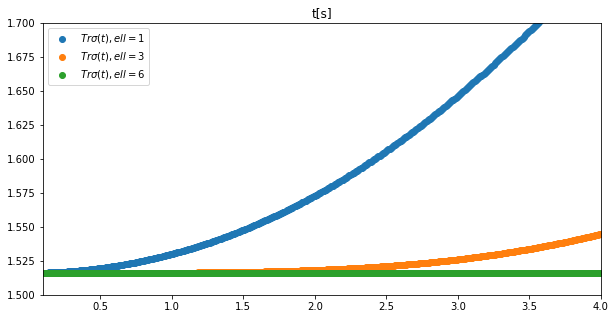

In [16]:
traces_rho_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Traces"]
traces_rho_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Traces"]
traces_rho_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Traces"]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(ts[:-1], traces_rho_HB0, label = r'$Tr \sigma(t), ell = 1$')

ax.scatter(ts[:-1], traces_rho_HB1, label = r'$Tr \sigma(t), ell = 3$')

ax.scatter(ts[:-1], traces_rho_HB2, label = r'$Tr \sigma(t), ell = 6$')
ax.legend(loc=0)
plt.xlim(0.1, 4.0)
plt.ylim(1.5, 1.7)
ax.set_title("t[s]")

### 3.2 von Neumann entropy of the restricted Max-Ent's states

Next, we are interested in computing the von Neumann entropy of our approximate states, in order to know if these are proper Max-Ent states, i.e. if the von Neumann entropy shows non-increasing behaviour. 

Text(0.5, 1.0, 'Von Neumann entropy on $\\rho$ and $\\sigma$')

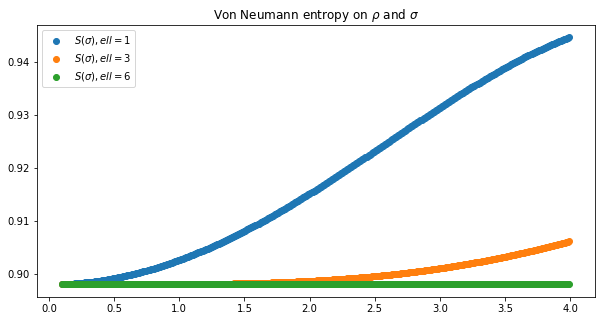

In [45]:
states_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["State_ev"]
states_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["State_ev"]
states_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["State_ev"]
states_exact = resultados["res_exact"]["res_exact_MaxEnt2"].states

entropy_HB0 = [qutip.entropy_vn(rhoHB0_at_timet) for rhoHB0_at_timet in states_HB0]
entropy_HB1 = [qutip.entropy_vn(rhoHB1_at_timet) for rhoHB1_at_timet in states_HB1]
entropy_HB2 = [qutip.entropy_vn(rhoHB2_at_timet) for rhoHB2_at_timet in states_HB2]
entropy_exact = [qutip.entropy_vn(rho) for rho in states_exact]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)

#ax.scatter(ts[:-1], entropy_exact[:-1], label = r'$S(\rho)$')
ax.scatter(ts[:-1], entropy_HB0, label = r'$S(\sigma), ell = 1$')
ax.scatter(ts[:-1], entropy_HB1, label = r'$S(\sigma), ell = 3$')
ax.scatter(ts[:-1], entropy_HB2, label = r'$S(\sigma), ell = 6$')

#plt.ylim(0.8970, 0.91)
ax.legend(loc=0)
ax.set_title(r'Von Neumann entropy on $\rho$ and $\sigma$')

In [135]:
resultados["res_exact"]['res_exact_MaxEnt2'].expect[2]
resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"]

[array([4.067, 4.067, 4.067, ..., 3.762, 3.761, 3.7600000000000002]),
 array([1.0110000000000001, 1.0110000000000001, 1.0110000000000001, ..., 1.0110000000000001, 1.0110000000000001,
        1.0110000000000001]),
 array([1.034, 1.034, 1.034, ..., 1.034, 1.034, 1.034])]

## FFT de los observables XX

Processing step:  1  and hierarchical basis of ℓ=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 6
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
basis_incursive_len 8
    |▼| 2. using a base of size  8
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the

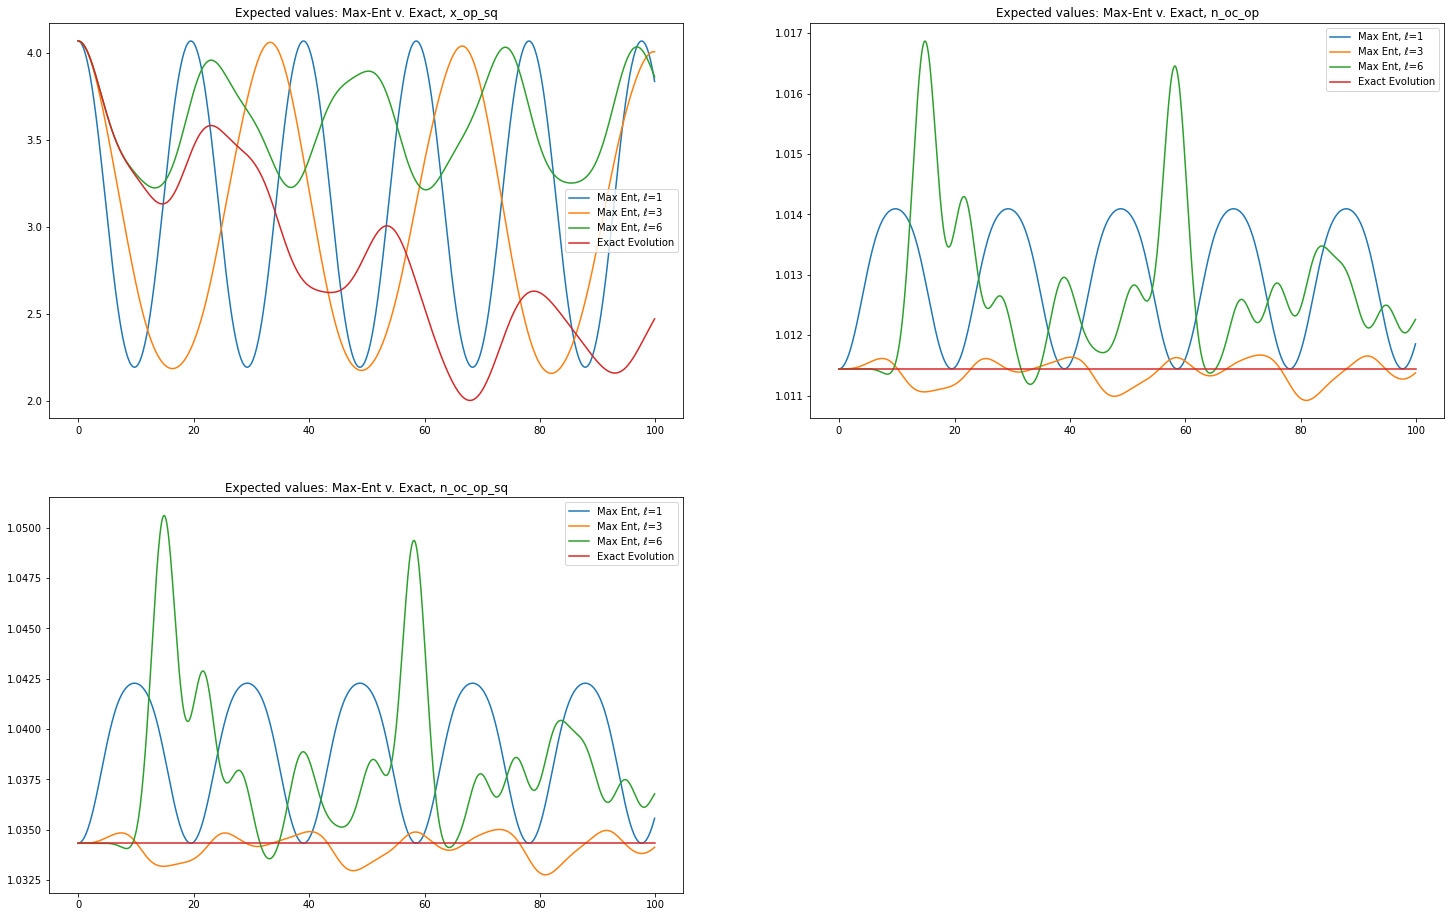

In [46]:
ts = np.linspace(1e-5, 100.0, 700)
fixed_ops_list = calB_basis_0

resultados = HBProjEv.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0,
                                                    rho_ref = rho_ref, 
                                                    range_HierarchBases_dims = depth_parameters, 
                                                     temp_ref = temp_ref, temp_rho = temp,
                                                     generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list,
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                                                 timespan = ts,
                                                 no_cols_desired = 2,
                                                 multiple_evolutions = resultados,
                                                 range_of_temps_or_dims = depth_parameters,
                                                  plot_var_HierarchBases_dim = True)

Text(0.5, 1.0, 'Von Neumann entropy on $\\rho$ and $\\sigma$')

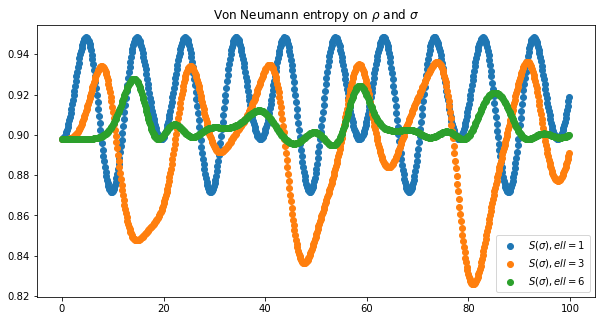

In [47]:
states_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["State_ev"]
states_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["State_ev"]
states_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["State_ev"]
states_exact = resultados["res_exact"]["res_exact_MaxEnt2"].states

entropy_HB0 = [qutip.entropy_vn(rhoHB0_at_timet) for rhoHB0_at_timet in states_HB0]
entropy_HB1 = [qutip.entropy_vn(rhoHB1_at_timet) for rhoHB1_at_timet in states_HB1]
entropy_HB2 = [qutip.entropy_vn(rhoHB2_at_timet) for rhoHB2_at_timet in states_HB2]
entropy_exact = [qutip.entropy_vn(rho) for rho in states_exact]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)

#ax.scatter(ts[:-1], entropy_exact[:-1], label = r'$S(\rho)$')
ax.scatter(ts[:-1], entropy_HB0, label = r'$S(\sigma), ell = 1$')
ax.scatter(ts[:-1], entropy_HB1, label = r'$S(\sigma), ell = 3$')
ax.scatter(ts[:-1], entropy_HB2, label = r'$S(\sigma), ell = 6$')

#plt.ylim(0.8970, 0.91)
ax.legend(loc=0)
ax.set_title(r'Von Neumann entropy on $\rho$ and $\sigma$')

In [ ]:
Gram0 = resultados["all_init_configs"]['init_configs_MaxEnt0']['Gram matrix']
Gram1 = resultados["all_init_configs"]['init_configs_MaxEnt1']['Gram matrix']
Gram2 = resultados["all_init_configs"]['init_configs_MaxEnt2']['Gram matrix']
Gram3 = resultados["all_init_configs"]['init_configs_MaxEnt3']['Gram matrix']

In [ ]:
A = [np.linalg.det(Gram0), np.linalg.det(Gram1), np.linalg.det(Gram2), np.linalg.det(Gram3)]

Text(0.5, 1.0, 't[s]')

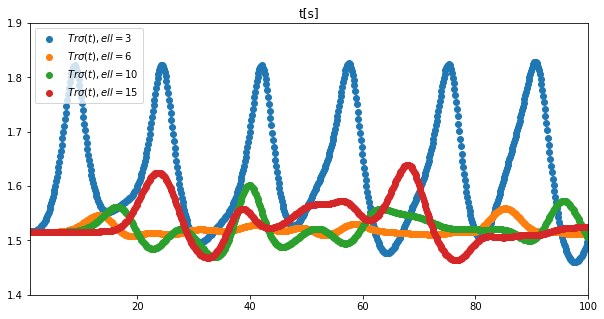

In [21]:
traces_rho_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Traces"]
traces_rho_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Traces"]
traces_rho_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Traces"]
traces_rho_HB3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["Traces"]

#traces_rho_HB0[0] = traces_rho_HB1[0] = traces_rho_HB2[0] = coeff_basis_t0[0]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(ts[:-1], traces_rho_HB0, label = r'$Tr \sigma(t), ell = 3$')
ax.scatter(ts[:-1], traces_rho_HB1, label = r'$Tr \sigma(t), ell = 6$')
ax.scatter(ts[:-1], traces_rho_HB2, label = r'$Tr \sigma(t), ell = 10$')
ax.scatter(ts[:-1], traces_rho_HB3, label = r'$Tr \sigma(t), ell = 15$')
ax.legend(loc=0)
plt.xlim(1, 100)
plt.ylim(1.4, 1.9)
ax.set_title("t[s]")

C:\Users\tomas\PhD Physics\2nd Year\Max_Ent_restricted_evs\Github Repo Docu\a_matrix_analysis_lib.py:366: RuntimeWarning: invalid value encountered in arccos
  return  np.arccos(fidelity)/np.pi


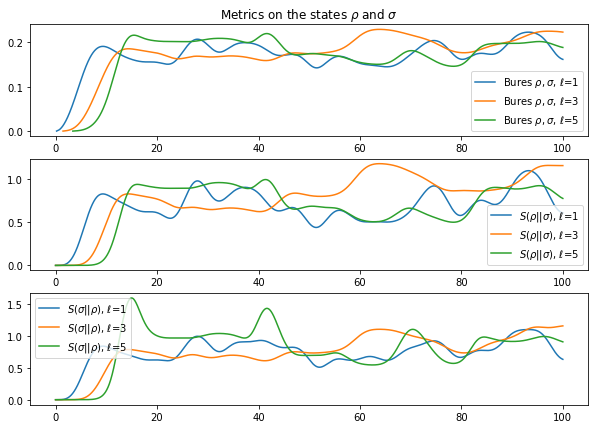

In [31]:
metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = depth_parameters,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = depth_parameters,
                                                     metric_local = metrics, cols = 1,
                                         plot_var_HierarchBases_dim = True)

In [32]:
avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]

avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt2'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]

freq_fft = np.fft.fftfreq(ts.shape[-1])
#freq_plot = [freq_fft[t] for t in range(len(freq_fft)) if (t <= -0.2 or t >= 0.2)]
freq_plot = freq_fft
freqs_fft_avgs_x_op_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_x_op_hb1 = np.fft.fft(avgs_xop_sq_HB0)[1:]
freqs_fft_avgs_x_op_hb3 = np.fft.fft(avgs_xop_sq_HB1)[1:]
freqs_fft_avgs_x_op_hb6 = np.fft.fft(avgs_xop_sq_HB2)[1:]

freqs_fft_avgs_all = [freqs_fft_avgs_x_op_hb1, freqs_fft_avgs_x_op_hb3, freqs_fft_avgs_x_op_hb6]

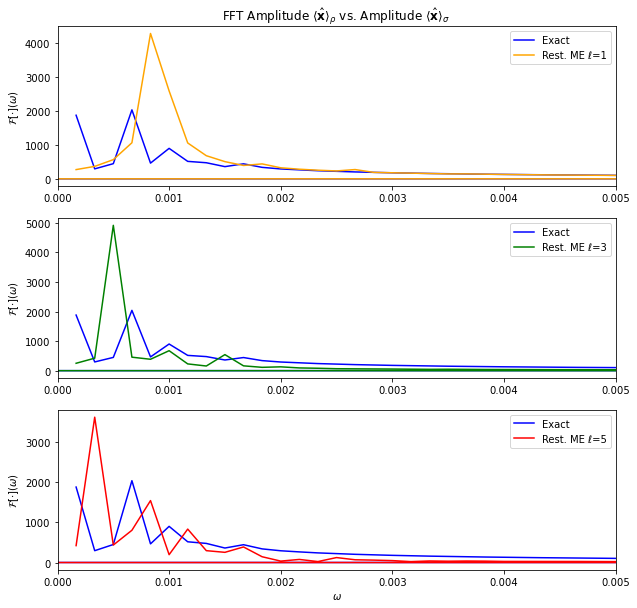

In [33]:
HB_dims = [1,3,5]
Tot = 3; Cols = 1
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(figsize=(10, 10))
colors = ["orange", "green", "red"]

for k in range(Tot):
    if k == 1:
        ax.set_title(r'FFT Amplitude $\langle \hat{\bf x} \rangle_{\rho}$ vs. Amplitude $\langle \hat{\bf x} \rangle_{\sigma}$')  
    ax = fig.add_subplot(Rows, Cols, Position[k])
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_exact.real + 1j * freqs_fft_avgs_x_op_exact.imag), color = "blue", label = "Exact")
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_all[k].real + 1j * freqs_fft_avgs_all[k].imag), color = colors[k], label = "Rest. ME ℓ=" + str(HB_dims[k]))
    plt.ylabel(r'${\cal F} [\cdot](\omega)$')
    if k == 2: 
        plt.xlabel(r'$\omega$')
    plt.xlim(0, .005)
    ax.legend(loc=0)